## 1 Motivation

  著名的神经网络API--Kears包的作者Frrancios Chollet在他的书籍<deep learning with python>的第6章第三节
介绍了RNN（循环神经网络）在预测气象数据上的应用，非常有趣。既然，可以利用神经网络预测气象数据，为什么不试试rnn在
预测其他的时间序列数据上的表现呢，比如股票或股票市场指数。这里我尝试在原书内容的基础上，使用keras的rnn预测
iex（老实说我也不知道它具体是某一个股票的价格指数还是类似道琼斯之类的一般性指数，whatever不影响工作）的下一时刻的指数（开市指数）。


## 2 数据准备
  我们直接从pandas_datareader中获取2年左右的指数数据。

In [1]:
import pandas_datareader.data as pdr
import datetime
import numpy as np
start = datetime.datetime(2015, 2, 9)
end = datetime.datetime(2017, 5, 24)

f = pdr.DataReader('F', 'iex', start, end) #iex data

5y


In [2]:
f.shape

(578, 5)

  这个数据和一般的股价信息一样，包含了时间（按日）、开市闭市交易量等信息。

In [3]:
f.head(20)

,open,high,low,close,volume
date,,,,,
2015-02-09,13.2238,13.4504,13.1903,13.3581,20286720
2015-02-10,13.4672,13.5427,13.3497,13.5007,27928530
2015-02-11,13.4923,13.6853,13.4336,13.6350,34285331
2015-02-12,13.7105,13.8028,13.6769,13.7273,23738806
2015-02-13,13.7021,13.7273,13.5846,13.6769,19954568
2015-02-17,13.6014,13.6769,13.4252,13.5175,44362323
2015-02-18,13.5595,13.7021,13.4756,13.6014,22812702
2015-02-19,13.5846,13.8280,13.5679,13.7860,24863932
2015-02-20,13.7525,13.8112,13.6350,13.7608,21523627


In [4]:
f.describe()

,open,high,low,close,volume
count,578.000000,578.000000,578.000000,578.000000,5.780000e+02
mean,11.923831,12.024981,11.801303,11.914646,3.320855e+07
std,0.896504,0.894503,0.915751,0.901509,1.510665e+07
min,9.977800,10.210100,8.932900,9.977800,7.760586e+06
25%,11.244450,11.315050,11.096400,11.214625,2.344138e+07
50%,11.858000,11.940250,11.740700,11.846900,2.924790e+07
75%,12.567600,12.668975,12.460600,12.576300,3.869472e+07
max,13.911900,14.046100,13.819600,13.903500,1.421686e+08


对数据进行标准化处理


In [5]:
#把数据转化成numpy array
time_data = f.as_matrix()

mean_data = time_data[:300].mean(axis=0)
sd_data = time_data[:300].std(axis=0)

time_data-= mean_data
time_data/= sd_data

定义一个batch data 生成器：

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=12, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0] #预测开始时间
        yield samples, targets

## 3 训练模型（1）--基线和一般MLP模型
  设定训练参数，以及通过刚才的生成器生成相应的训练，测试数据集

In [7]:

float_data = time_data
lookback = 14 #two weeks to look back
step = 1  #every day
delay = 1 #one day later
batch_size = 10

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=300,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=301,
                    max_index=450,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=451,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (450 - 301 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 451 - lookback) // batch_size

设定一个baseline，这个baseline假定下一个时刻的数据和当前时刻相同

In [8]:
#naive estimator
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)  #next 不断调用下个时刻的数据
        preds = samples[:, -1, 0]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()
#可以啊看到这个baseline的误差在0.175左右

0.17493463958816186


  使用由普通的full connected dense layor的MLP来进拟合：

In [9]:
#basic machine learning base line
from keras.models import Sequential
from keras import layers
from keras.optimizers import Nadam

model_mlp = Sequential()
model_mlp.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))#input size:14*5
model_mlp.add(layers.Dense(32, activation='relu'))
model_mlp.add(layers.Dense(1))

model_mlp.compile(optimizer=Nadam(), loss='mae') #使用adam的optimazir和绝对值误差作为lossfunction
history = model_mlp.fit_generator(train_gen,
                              steps_per_epoch=batch_size, 
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/Users/jiangchaodi/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
10/10 [==============================] - 0s 44ms/step - loss: 0.4704 - val_loss: 0.4902
Epoch 2/20
10/10 [==============================] - 0s 3ms/step - loss: 0.4068 - val_loss: 0.4769
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4084 - val_loss: 0.4556
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3768 - val_loss: 0.3868
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3855 - val_loss: 0.3741
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3709 - val_loss: 0.3829
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.366 - 0s 4ms/step - loss: 0.2585 - val_loss: 0.4197
Epoch 8/20
10/10 [==============================] - 0s 3ms/step - loss: 0.3112 - val_loss: 0.3583
Epoch 9/20
10/10 [==============================] - 0s 4ms/step - loss: 0.2822 - val_loss: 0.4404
Epoch 10/20
10/10 [==============================] - 0s 3ms/step - loss: 0.3116 - val_loss: 0

  下面用matplot来再现训练过程：

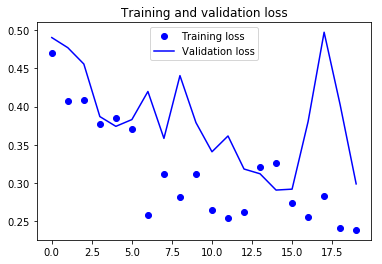

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

history.history

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

   可以看到train_loss 和 validation_loss整体上同时都在下降，没有出现明显的过拟合的状况（Training_loss和validation_loss一个往下走，一个往上走），只是最后的validation_loss 要远高于我们的基线。

## 4 训练模型（2）--RNN和dropout的应用

In [12]:
#base rnn base line
from keras.models import Sequential
from keras import layers
from keras.optimizers import Nadam

model_rnn = Sequential()
model_rnn.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) #使用GRU作为门控，门控的其中一个
#重要作用是防止梯度衰减
model_rnn.add(layers.Dense(1))

model_rnn.compile(optimizer=Nadam(), loss='mae')
history = model_rnn.fit_generator(train_gen,
                              steps_per_epoch=batch_size,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
10/10 [==============================] - 1s 104ms/step - loss: 0.1988 - val_loss: 0.2329
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 0.2203 - val_loss: 0.1995
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 0.1844 - val_loss: 0.1836
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 0.1998 - val_loss: 0.2559
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 0.2107 - val_loss: 0.2039
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 0.1772 - val_loss: 0.2193
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2219 - val_loss: 0.2708
Epoch 8/20
10/10 [==============================] - 0s 14ms/step - loss: 0.2202 - val_loss: 0.2578
Epoch 9/20
10/10 [==============================] - 0s 14ms/step - loss: 0.1943 - val_loss: 0.2085
Epoch 10/20
10/10 [==============================] - 0s 17ms/step - loss: 0.1929 - val_loss: 0.2109
Epoch 11

  matplot再现训练过程：

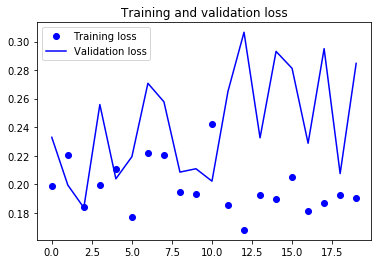

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

  可以看到我们RNN模型的训练效果非常不好，出现了过拟合，且误差波幅大，在此基础上我们试着加上dropout

In [14]:
#use drop out to overcome over fiiting
from keras.models import Sequential
from keras import layers
from keras.optimizers import Nadam

model_dropout = Sequential()
model_dropout.add(layers.GRU(32,
                     dropout=0.1, #dropout for input data
                     recurrent_dropout=0.1, #drop out for recurrent unit
                     input_shape=(None, float_data.shape[-1])))
model_dropout.add(layers.Dense(1))

model_dropout.compile(optimizer=Nadam(), loss='mae')
history = model_dropout.fit_generator(train_gen,
                              steps_per_epoch=batch_size,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
10/10 [==============================] - 1s 120ms/step - loss: 0.6581 - val_loss: 0.5146
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 0.3345 - val_loss: 0.2230
Epoch 3/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2491 - val_loss: 0.2086
Epoch 4/20
10/10 [==============================] - 0s 18ms/step - loss: 0.2399 - val_loss: 0.2084
Epoch 5/20
10/10 [==============================] - 0s 18ms/step - loss: 0.2447 - val_loss: 0.2035
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2583 - val_loss: 0.1875
Epoch 7/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2829 - val_loss: 0.2045
Epoch 8/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2585 - val_loss: 0.1973
Epoch 9/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2319 - val_loss: 0.1799
Epoch 10/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2163 - val_loss: 0.2047
Epoch 11

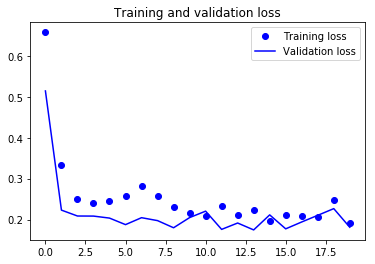

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

可以看到在加入了drop_out项之后整个模型的表现大幅提升。

## 5 多层RNN和双向RNN

  上面的单层RNN的hidden layer参数只和上一个时刻的hidden layor的参数呈线性关系。而多层RNN的hidden layer
 中的参数不仅和同一层RNN的上一时刻相关,也和同一时刻的上一层RNN相关。

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Nadam

model_multi = Sequential()
model_multi.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.3,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model_multi.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.3))
model_multi.add(layers.Dense(1))

model_multi.compile(optimizer=Nadam(), loss='mae')
history = model_multi.fit_generator(train_gen,
                              steps_per_epoch=batch_size,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
10/10 [==============================] - 3s 254ms/step - loss: 0.5502 - val_loss: 0.3329
Epoch 2/20
10/10 [==============================] - 0s 28ms/step - loss: 0.3463 - val_loss: 0.2671
Epoch 3/20
10/10 [==============================] - 0s 27ms/step - loss: 0.3084 - val_loss: 0.2441
Epoch 4/20
10/10 [==============================] - 0s 27ms/step - loss: 0.3452 - val_loss: 0.2151
Epoch 5/20
10/10 [==============================] - 0s 27ms/step - loss: 0.2505 - val_loss: 0.3403
Epoch 6/20
10/10 [==============================] - 0s 27ms/step - loss: 0.2679 - val_loss: 0.2426
Epoch 7/20
10/10 [==============================] - 0s 27ms/step - loss: 0.2949 - val_loss: 0.3174
Epoch 8/20
10/10 [==============================] - 0s 33ms/step - loss: 0.2690 - val_loss: 0.2844
Epoch 9/20
10/10 [==============================] - 0s 33ms/step - loss: 0.2396 - val_loss: 0.2900
Epoch 10/20
10/10 [==============================] - 0s 31ms/step - loss: 0.2837 - val_loss: 0.3391
Epoch 11

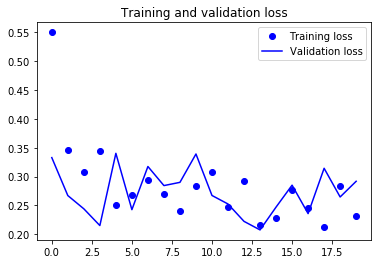

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

  我们使用了多层RNN来进行训练，模型表现反而更差了，下面我们将使用双向RNN来训练模型。

In [18]:
#use drop out to overcome over fiiting
from keras.models import Sequential
from keras import layers
from keras.optimizers import Nadam

model_bi = Sequential()
model_bi.add(layers.Bidirectional(layers.GRU(32),
                     input_shape=(None, float_data.shape[-1])))
model_bi.add(layers.Dense(1))

model_bi.compile(optimizer=Nadam(), loss='mae')
history = model_bi.fit_generator(train_gen,
                              steps_per_epoch=batch_size,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
10/10 [==============================] - 2s 190ms/step - loss: 0.6630 - val_loss: 0.4470
Epoch 2/20
10/10 [==============================] - 0s 15ms/step - loss: 0.3253 - val_loss: 0.2726
Epoch 3/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2323 - val_loss: 0.2269
Epoch 4/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2665 - val_loss: 0.2437
Epoch 5/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2421 - val_loss: 0.2214
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2360 - val_loss: 0.2069
Epoch 7/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2475 - val_loss: 0.3579
Epoch 8/20
10/10 [==============================] - 0s 19ms/step - loss: 0.2731 - val_loss: 0.2634
Epoch 9/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2124 - val_loss: 0.2209
Epoch 10/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2040 - val_loss: 0.2290
Epoch 11

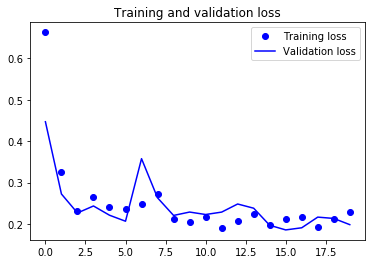

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

  双向RNN的vladation loss的表现还不错，但略逊于是用来drop_out的RNN。需要注意的是，我们的input data都经过
 标准化处理，所以真实误差还需要乘以原来的标准差。

In [20]:
#以双向RNN的最后的val_loss为例
0.1987 * sd_data[0]  #这才是真实误差

0.18138520718855444

## 6 用模型进行预测

 基于进入模型的数据大小（14*5），我们选取原数据的最后14行并用表现最好的初始RNN来预测数据。

In [22]:
inputdata = np.zeros((1,14,5))
inputdata[0] = f[-14:]

In [23]:
#使用表现做好的模型进行预测
prediction = model_dropout.predict(inputdata)

In [24]:
prediction = prediction*sd_data[0]+mean_data[0]
prediction

array([[12.743471]], dtype=float32)

In [28]:
#
start = datetime.datetime(2017,5,24)
end = datetime.datetime(2017,5,25)
new = pdr.DataReader('F', 'iex', start, end)

1y


In [29]:
new.loc[:,'open']

date
2017-05-24    10.5281
2017-05-25    10.4329
Name: open, dtype: float64

  基于我们的模型得到的预测是12.74，然而2017年5月25日的真实指数为10.43，考虑到标准差小于1，可以说这个预测还是比较糟糕的。